In [1]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add relative path
import open3d as o3d
from plyfile import PlyData, PlyElement

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

/home/neal/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### Define STTR model

In [2]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [3]:
model = STTR(args).cuda().eval()

In [4]:
# Load the pretrained model
model_file_name = "../kitti_finetuned_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


### Read image

In [5]:
left = np.array(Image.open('../sample_data/dataset_1/left/images/0247.png'))
right = np.array(Image.open('../sample_data/dataset_1/right/images/0247.png'))

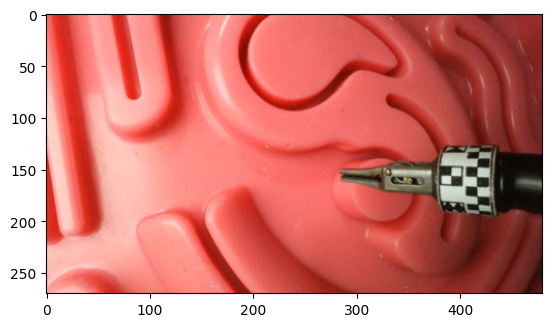

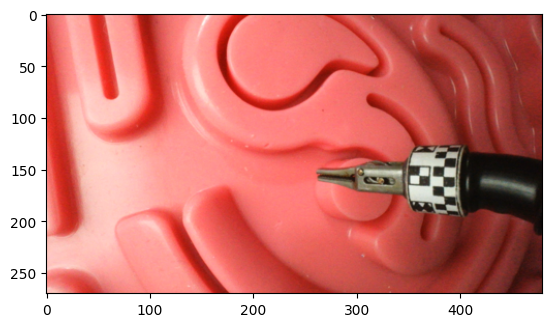

In [6]:
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)

Preprocess data for STTR

In [7]:
# normalize
input_data = {'left': left, 'right':right}
input_data = normalization(**input_data)

In [8]:
# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 1
col_offset = int(downsample / 2)  # 1
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

In [9]:
# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

### Inference

In [10]:
output = model(input_data)

/home/neal/projects/STTR_matching/notebook/../module/pos_encoder.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [20]:
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0
disp_pred[153,330:373]

array([26.012394, 26.050705, 26.089079, 26.108307, 26.130604, 26.161684,
       26.191269, 26.225183, 26.247887, 26.291206, 26.334536, 26.369656,
       26.409443, 26.460102, 26.517082, 26.551273, 26.592972, 26.626282,
       26.650887, 26.689428, 26.738264, 26.76825 , 26.789845, 26.804924,
       26.813011, 26.809866, 26.799572, 26.793236, 26.784267, 26.771748,
       26.77459 , 26.80383 , 26.8199  , 26.824871, 26.834513, 26.84109 ,
       26.872412, 26.94374 , 27.150122, 27.370102, 27.671432, 27.819267,
       28.193047], dtype=float32)

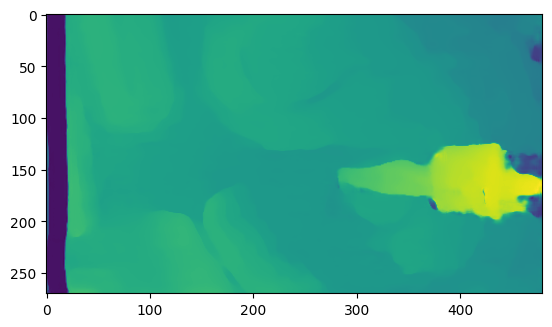

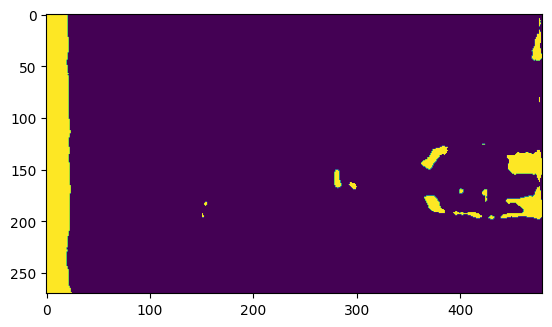

In [12]:
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

In [13]:
# camera intrinsic
A_cam = np.array([[1194.072289*0.25, 0.0, 960*0.25],
                  [0.0, 1194.072289*0.25, 540*0.25],
                  [0.0,     0.0, 1.0]], dtype=np.float32)
b_dis = 4.05

# calculate XYZ
points_Z0 = A_cam[0,0]*b_dis/(disp_pred)
u_mesh = np.linspace(1,disp_pred.shape[1],disp_pred.shape[1])[None,:]
u_mesh = np.concatenate([u_mesh for i in range(disp_pred.shape[0])],axis=0)
points_X0 = points_Z0*(u_mesh-A_cam[0,2])/A_cam[0,0]
v_mesh = np.linspace(1,disp_pred.shape[0],disp_pred.shape[0])[:,None]
v_mesh = np.concatenate([v_mesh for i in range(disp_pred.shape[1])],axis=1)
points_Y0 = points_Z0*(v_mesh-A_cam[1,2])/A_cam[1,1]
points = np.concatenate((points_X0.flatten()[:,None],points_Y0.flatten()[:,None],points_Z0.flatten()[:,None]), axis=1)

points_mask = (points[:,2]>0) & (points[:,2]<150)
points = points[points_mask,:]

# visualize
pcd = o3d.geometry.PointCloud()
pcd.points=o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

# save ply
def write_ply(points, filename):
    points = [(points[i,0], points[i,1], points[i,2]) for i in range(points.shape[0])]
    vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
    el = PlyElement.describe(vertex, 'vertex', comments=['vertices'])
    PlyData([el], text=True).write(filename)
write_ply(points, 'scene.ply')

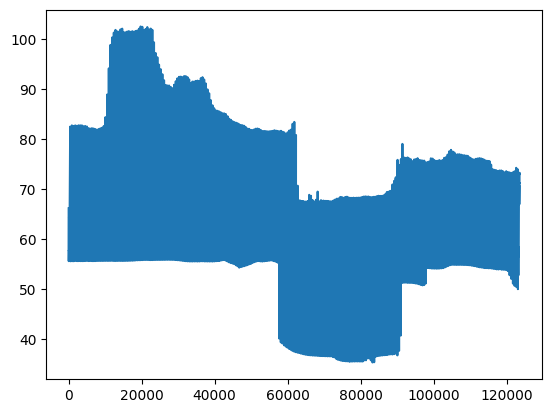

In [15]:
# 绘图
plt.plot(np.arange(points.shape[0]),points[:,2])

plt.show()


In [65]:
from autolab_core import Logger, RigidTransform
import numpy as np

# pose = [17.8609, 1.55835, 36.3751, 0.780886, 0.240198, -0.547831, -0.180005]  # 1
pose = [8.24247, 3.00099, 42.5379, 0.794202, 0.142026, -0.551856, -0.211013]  # 131

T_qua2rota = RigidTransform(
    rotation=np.array([pose[3], pose[4], pose[5], pose[6]]),
    translation=np.array([pose[0], pose[1], pose[2]]),
    from_frame="marker_5",
    to_frame="world",
)
T4 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([0.0,0.0,13.1]),
    from_frame="shuangji2_4",
    to_frame="shuangji_3",
)
T5 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(np.pi/2),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="shuangji2_5",
    to_frame="shuangji2_4",
)
T6 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(np.pi),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="shuangji2_6",
    to_frame="shuangji2_5",
)

T2_4 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([1.2, 0, 13.11-6.10]),
    from_frame="shuangji3_4",
    to_frame="shuangji_3",
)            
T2_5 = RigidTransform(
    rotation=RigidTransform.y_axis_rotation(0),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="shuangji3_5",
    to_frame="shuangji3_4",
)            
T2_6 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([0.79-1.2, 0, 6.10]),
    from_frame="shuangji3_6",
    to_frame="shuangji3_5",
)
T2_7 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(np.pi/2),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="shuangji3_7",
    to_frame="shuangji3_6",
)            
T2_8 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(-np.pi/2),
    translation=np.array([0,0,0]),
    from_frame="shuangji3_8",
    to_frame="shuangji3_7",
)


Tm_4 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation((45)*np.pi/180),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="marker_4",
    to_frame="shuangji_3",
)
Tm_5 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([0, 0, -4.5]),  #-(- 4.237 + 6.3 + 1.3)
    from_frame="marker_5",
    to_frame="marker_4",
)            

pose = T_qua2rota*(Tm_4*Tm_5).inverse()*(T4*T5*T6)
pose2 = T_qua2rota*(Tm_4*Tm_5).inverse()*(T2_4*T2_5*T2_6*T2_7*T2_8)
pose0 = T_qua2rota*(Tm_4*Tm_5).inverse()  # world_T_base

In [66]:
from scipy.spatial.transform import Rotation as R
R0_predict = R.from_euler('xyz', np.array([1.280643, 0.598192, -1.591921])*180/np.pi, degrees=True).as_matrix()
R0_gt = pose0.rotation

In [67]:
z0_predict = R0_predict[:,1]
z0_gt = R0_gt[:,1]
angle = np.degrees(np.arccos(np.dot(z0_predict, z0_gt)))
angle

48.61369465606663

In [68]:
np.degrees(np.pi)

180.0

In [69]:
R0_gt

array([[ 0.08728428,  0.33960563, -0.93650919],
       [-0.96345707,  0.26776323,  0.00730292],
       [ 0.25324284,  0.90164897,  0.35056697]])

In [70]:
pose0.translation

array([ 4.02817863,  3.03385312, 44.11545135])

In [8]:
pose.quaternion

array([-0.01226818,  0.79033007,  0.13252929,  0.59805005])

In [9]:
pose.translation

array([ 1.28060721, -1.57286805, 41.38003402])

In [18]:
pose2.quaternion

array([ 0.56752266, -0.55017284, -0.51659761, -0.32917289])

In [19]:
pose2.translation

array([ 1.4482712 , -2.33665821, 41.49278765])

In [96]:
from autolab_core import Logger, RigidTransform
import numpy as np
pose = [-1.6515535,  16.508718 ,  79.10953  ,  93.21003  , 184.0589   ,325.77628]

# dingqiantou
Tw = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(np.pi),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="camera",
    to_frame="world",
)
T0 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(0.0),
    translation=np.array([pose[0], pose[1], pose[2]]),
    from_frame="chizhen_0",
    to_frame="camera",
)
T1 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(pose[5]*np.pi/180),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen_1",
    to_frame="chizhen_0",
)
T2 = RigidTransform(
    rotation=RigidTransform.y_axis_rotation(pose[4]*np.pi/180),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen_2",
    to_frame="chizhen_1",
)
T3 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(pose[3]*np.pi/180),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen_3",
    to_frame="chizhen_2",
)
T4 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(0.0),
    translation=np.array([0, 0, 13.1]),
    from_frame="chizhen1_4",
    to_frame="chizhen_3",
)
T5 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(np.pi/2),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen1_5",
    to_frame="chizhen1_4",
)
T6 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(np.pi),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen1_6",
    to_frame="chizhen1_5",
)

# dongqiantou
T2_4 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([1.2, 0, 13.11-6.10]),
    from_frame="chizhen3_4",
    to_frame="chizhen_3",
)            
T2_5 = RigidTransform(
    rotation=RigidTransform.y_axis_rotation(0),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen3_5",
    to_frame="chizhen3_4",
)            
T2_6 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(0),
    translation=np.array([0.79-1.2, 0, 6.10]),
    from_frame="chizhen3_6",
    to_frame="chizhen3_5",
)
T2_7 = RigidTransform(
    rotation=RigidTransform.z_axis_rotation(np.pi/2),
    translation=np.array([0.0,0.0,0.0]),
    from_frame="chizhen3_7",
    to_frame="chizhen3_6",
)            
T2_8 = RigidTransform(
    rotation=RigidTransform.x_axis_rotation(-np.pi/2),
    translation=np.array([0,0,0]),
    from_frame="chizhen3_8",
    to_frame="chizhen3_7",
)


pose = T0*T1*T2*T3*T4*T5*T6
pose2 = T0*T1*T2*T3*T2_4*T2_5*T2_6*T2_7*T2_8

In [1]:
pose.translation


NameError: name 'pose' is not defined

In [ ]:
pose.rotation

In [ ]:
pose2.quaternion

In [ ]:
pose2.translation

In [ ]:

Tw*T0*T1*T2*T3

In [2]:
import numpy as np
from plyfile import PlyData, PlyElement
from scipy.spatial.transform import Rotation

def write_ply(points, filename):
    """ input: Nx3, write points to filename as PLY format. """
    points = [(points[i,0], points[i,1], points[i,2]) for i in range(points.shape[0])]
    vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
    el = PlyElement.describe(vertex, 'vertex', comments=['vertices'])
    PlyData([el], text=True).write(filename)
    
points_data = np.load('000000_pc.npz')['pc']
bbox = np.load('000000_bbox.npy')
print(bbox)
point_votes = np.load('000000_votes.npz')['point_votes']
# write_ply(points_data, "000000_pc.ply")

euler = bbox[0,3:6]
R = Rotation.from_euler('XYZ',euler)
print(R.as_euler('xyz',degrees=True))

[[-1.6515535 16.508718  79.10953    1.5034218 -0.5922942  3.0329883]]
[-86.78997085  -4.05890558 145.77628869]


In [3]:
R_bbox = R.as_matrix()
print(R_bbox)
R_bbox[1,0] = -R_bbox[1,0]
R_bbox[2,0] = -R_bbox[2,0]
R_bbox[0,1] = -R_bbox[0,1]
R_bbox[0,2] = -R_bbox[0,2]
print(Rotation.from_matrix(R_bbox).as_euler('xyz',degrees=True))

[[-0.824774   -0.08992788 -0.55826591]
 [ 0.56101494 -0.00655324 -0.82777974]
 [ 0.07078203 -0.99592672  0.05585582]]
[ -86.78997085    4.05890558 -145.77628869]


In [11]:
def rotz(t):
    """Rotation about the z-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s,  0],
                     [s,  c,  0],
                     [0,  0,  1]])

rot_mat = rotz(np.pi/6)
print(rot_mat)
print(np.dot(np.array([-1.6515535, 16.508718, 79.10953]), np.transpose(rot_mat)))



print(Rotation.from_matrix(np.dot(rot_mat, R.as_matrix())).as_matrix())

[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
[-9.68464629 13.47119242 79.10953   ]
[[-0.9947827  -0.07460321 -0.06958259]
 [ 0.07346619 -0.05063921 -0.99601124]
 [ 0.07078203 -0.99592672  0.05585582]]


In [8]:
0.5*-1.6515535+0.8660254*16.508718

13.471192359437199

In [68]:
import numpy as np
from scipy.signal import convolve2d

a = np.zeros((7,7))
a[2:5,2:5] = np.random.rand(3,3)
print(a)
kernel1 = np.asarray([[0,1,0],[1,1,1],[0,1,0]])
mask1 = np.where(a>0.01, 1, 0)
mean1 = convolve2d(a,kernel1,mode='same') / convolve2d(a.astype(bool).astype(int),kernel1.astype(int),mode='same')
mean1 *= mask1
print(mean1)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.1237272  0.24927246 0.43868665 0.
  0.        ]
 [0.         0.         0.09739416 0.99279863 0.60590255 0.
  0.        ]
 [0.         0.         0.52275417 0.49366894 0.70186315 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[       nan        nan        nan        nan        nan        nan
         nan]
 [       nan        nan 0.         0.         0.                nan
         nan]
 [       nan 0.         0.15679794 0.45112123 0.43128722 0.
         nan]
 [       nan 0.         0.43416854 0.48780734 0.68481274 0.
         nan]
 [       nan 0.         0.37127242 0.67777122 0.60047821 0.
         nan]
 [       nan        nan 0.         0.         0.                nan
         nan]
 [       nan 

/tmp/ipykernel_21516/3536037090.py:9: RuntimeWarning: invalid value encountered in true_divide
  mean1 = convolve2d(a,kernel1,mode='same') / convolve2d(a.astype(bool).astype(int),kernel1.astype(int),mode='same')


In [70]:
np.where(mean1>0.01)

(array([2, 2, 2, 3, 3, 3, 4, 4, 4]), array([2, 3, 4, 2, 3, 4, 2, 3, 4]))